In [1]:
#python version
!python -V

Python 3.13.5


In [14]:
import pandas as pd #like excel-in-python

In [7]:
import pickle 
"""
 The pickle library in Python is a built-in module that provides a way to serialize and deserialize Python objects.
This process, known as pickling and unpickling,
 allows you to convert Python objects into a byte stream (serialization) and then reconstruct them from that byte stream (deserialization).
"""


'\n The pickle library in Python is a built-in module that provides a way to serialize and deserialize Python objects.\nThis process, known as pickling and unpickling,\n allows you to convert Python objects into a byte stream (serialization) and then reconstruct them from that byte stream (deserialization).\n'

In [8]:
import seaborn as sns #our paintbrush
import matplotlib.pyplot as plt #paintbrush basic

In [12]:
#sklearn, short for Scikit-learn, is like a Swiss army knife for machine learning in Python
# with sklearn you can prepare data, train, evaluate, and predict
from sklearn.feature_extraction import DictVectorizer #turns a dictionary into vectors [0,1,1,0,0] for machine to understand
from sklearn.linear_model import LinearRegression # draw a straight line throw that fits the points
from sklearn.linear_model import Lasso 
"""
Lasso is a smarter version of linear regression that tries to ignore unnecessary data.
It says:
“Hey, I’ll still draw a line—but if I see a feature (column) that isn’t helping, I’ll shrink its importance down to zero.”
"""
from sklearn.linear_model import Ridge
"""
Ridge is another upgraded version of Linear Regression.

Instead of cutting features to zero like Lasso, Ridge says:

“I’ll keep all features, but I’ll gently reduce their impact if they’re too wild.”
"""
from sklearn.metrics import root_mean_squared_error #accuracy scorecard, on average, how big are my mistakes? the lower the better


In [22]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet') #read the parquet file (columnar data) into a dataframe ( a spreadsheet or a table in python)
print(df.head(10))
print(df.tail(10))
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime #define the duration column (feature) which is dropoff time - pickup time
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) #convert to minutes
#A timedelta object represents a duration of time, not a specific date.
df = df[(df.duration >= 1) & (df.duration <= 60)] #keep only from 1 to 60

categorical = ['PULocationID', 'DOLocationID'] #define them as categories so it does not intercept them as integers
numerical = ['trip_distance'] #keep this one numerical



   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2021-01-01 00:15:56   2021-01-01 00:19:52                  N   
1         2  2021-01-01 00:25:59   2021-01-01 00:34:44                  N   
2         2  2021-01-01 00:45:57   2021-01-01 00:51:55                  N   
3         2  2020-12-31 23:57:51   2021-01-01 00:04:56                  N   
4         2  2021-01-01 00:16:36   2021-01-01 00:16:40                  N   
5         2  2021-01-01 00:16:36   2021-01-01 00:16:40                  N   
6         2  2021-01-01 00:19:14   2021-01-01 00:19:21                  N   
7         2  2021-01-01 00:26:31   2021-01-01 00:28:50                  N   
8         2  2021-01-01 00:57:46   2021-01-01 00:57:57                  N   
9         2  2021-01-01 00:58:32   2021-01-01 01:32:34                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            43           151              1.0           1.01  

In [24]:
df[categorical] = df[categorical].astype(str) # convert the values in the columns (that are in categorical) to strings instead of numbers  # grab the categorical values and convert them to strings, numbers means they are all as important as others
train_dicts = df[categorical + numerical].to_dict(orient='records') #concatenate the two lists into one and convert them to dictionaries ( each row now become a dictionary ["PULocationID", "DOLocationID, "trip_distance"] )
dv = DictVectorizer() # this is a translator to translate the dictionaries into numeric arrays python understands ( a dictionary-to-numbers compiler )

#now we want to fit and transform, the fit will learn what categories we have and what numeric columns we have , and then transform will turn them into numeric rows python understands
#fit ( learn the rules from data ) and transform ( apply those rules to turn data into numbers)

X_train = dv.fit_transform(train_dicts) 

target = 'duration' # the column we want to predict
y_train = df[target].values # get the target column and convert it to an array of numbers [12.3, 5.7 .. ]

lr = LinearRegression() #create a LinearRegression model and call it lr
lr.fit(X_train, y_train) # give the model the input features and the correct answers, the model now learns this data and figures out the best set of weights to connect the input to the output

y_pred = lr.predict(X_train) # now we give the model the same inputs and ask, now that you've learned, what do you think the answers are, it applies the learning formula and outputs predicted durations
print(y_pred)
root_mean_squared_error(y_train, y_pred) #on average, how many mintes off are we?, if it is 9, then we're off by 9 minutes

[ 7.66699166 13.74297398  8.40093639 ... 14.10827344 17.00908765
 19.87761864]


9.838799799825003

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


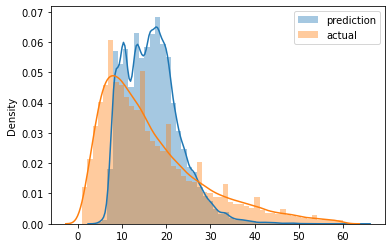

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()
#the model tends to predict trips as longer and more average than they really are.

#The orange curve spreads wider (some very short, some very long).

#The blue curve is more concentrated — the model doesn’t dare predict extremes, it sticks to the safe middle.

In [27]:
# a helper function to read a parquet file, and return a cleaned df
# 
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [29]:
#read one file for training and one for validation
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [30]:
len(df_train), len(df_val)

(73908, 61921)

In [31]:
"""
Make a new column PU_DO by concatenating pickup and dropoff IDs (e.g., "130_205").

This captures routes, not just isolated locations.

Example: "JFK → Manhattan" might behave differently than "Brooklyn → Manhattan" even if distance is similar.
"""
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [33]:
"""
Now we only use the combined categorical PU_DO instead of separate PU/DO.

Still keep trip_distance as a numeric feature.

So our model has 2 types of features: route + distance.
"""
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
"""
Select the categorical + numeric columns.

Convert rows into list of dicts.

fit_transform: learn the feature mapping and build the training matrix.
"""
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
"""
Do the same conversion to dicts.

Only call transform (not fit) — use the same mapping learned on training data.

Ensures columns match between training and validation.
"""

X_val = dv.transform(val_dicts)

In [34]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

/tmp/ipykernel_6149/3860639932.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='prediction')
/tmp/ipykernel_6149/3860639932.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='actual')


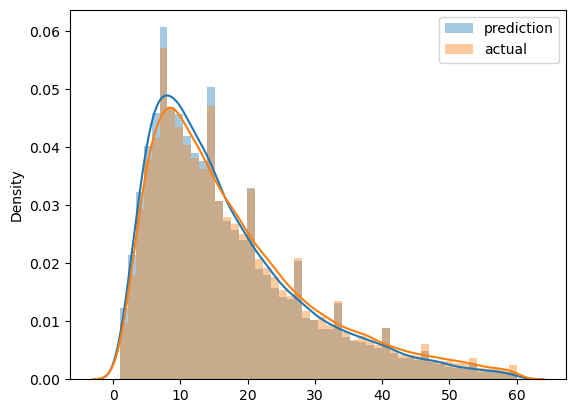

In [36]:
sns.distplot(y_train, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.75871520645115

In [38]:
#save the model & vectorizer we already trained
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

FileNotFoundError: [Errno 2] No such file or directory: 'models/lin_reg.bin'

In [40]:
#try out a different model (Lasso regression) to see if it does better
"""
Create a new regression model, but this time it’s Lasso instead of plain LinearRegression.

0.01 is the alpha parameter (regularization strength).

Larger alpha = stronger penalty, forces the model to shrink or zero-out less important coefficients.

This helps prevent overfitting, especially with many categorical variables.

👉 In plain English: Lasso says “hey, keep it simple — don’t rely too heavily on too many features.”
"""
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

11.167275941179728